In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Visualization
Before proceeding with our data modelling and analysis we decided to have an overlook on the dataset. This was made by following some advices from NLP theory and some insights discovered during the process. We strongly believe that our Data visualization helped us to learn a lot from our dataset. The most important part treated in our visualization is surely feature creation and respective target distribution. At the beginning of our work we had many issues improving the model and understanding if and how creating new features.

### **Missing Values**
Training and test set have same ratio of missing values in features `keyword` and `location`.
* **0.8%** for `keyword` 
* **33%** for `location` 

Since missing value ratios between training and test set are too close, they are most probably taken from the same sample. Afterwords keyword and location are going to be removed.

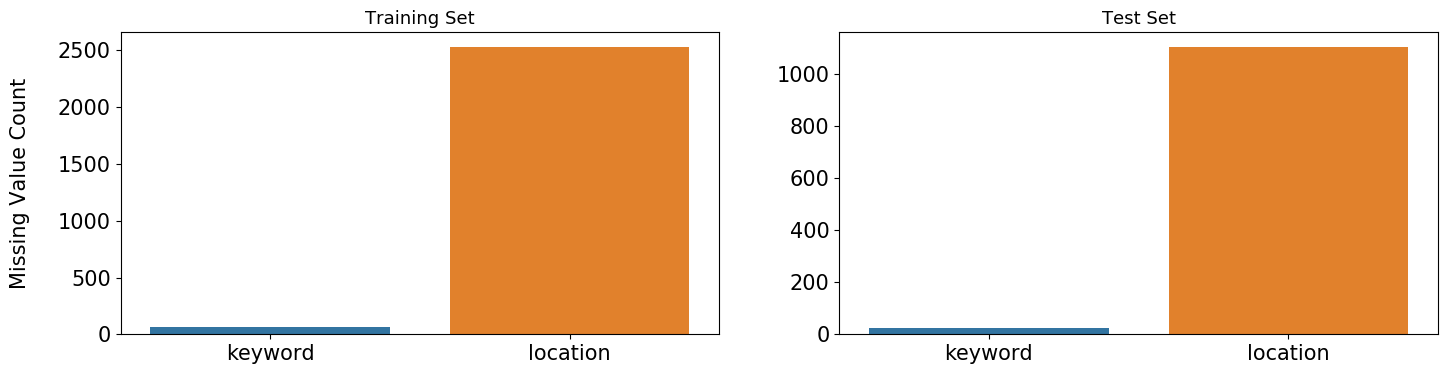

In [238]:
import matplotlib.pyplot as plt

missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=test[missing_cols].isnull().sum().index, y=train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=test[missing_cols].isnull().sum().index, y=test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

##### Target distribution on keyword
Visualization of what we can detect from keyword, we can see that is avery interesting feature for the target definition. Keeping this in ming we continue with the data understanding, maybe keyword is going to result very important for the prediction

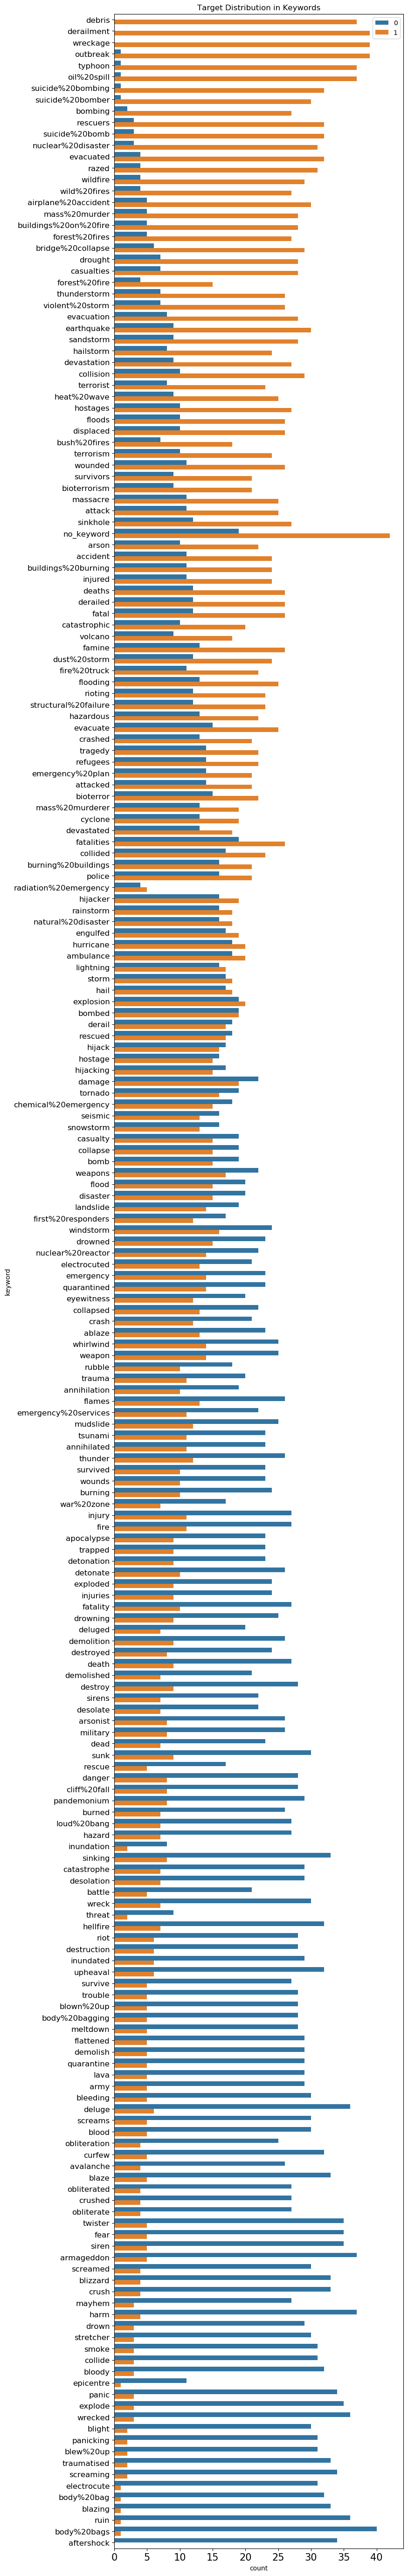

In [240]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

### **Possible new features**
New features can be helpful to identify disaster. The new features used for the analysis are: ## Cycy this part use it when you do feature creation
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text

In [243]:
# punctuation_count
import string
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# stop_word_count
from wordcloud import STOPWORDS
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))


# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

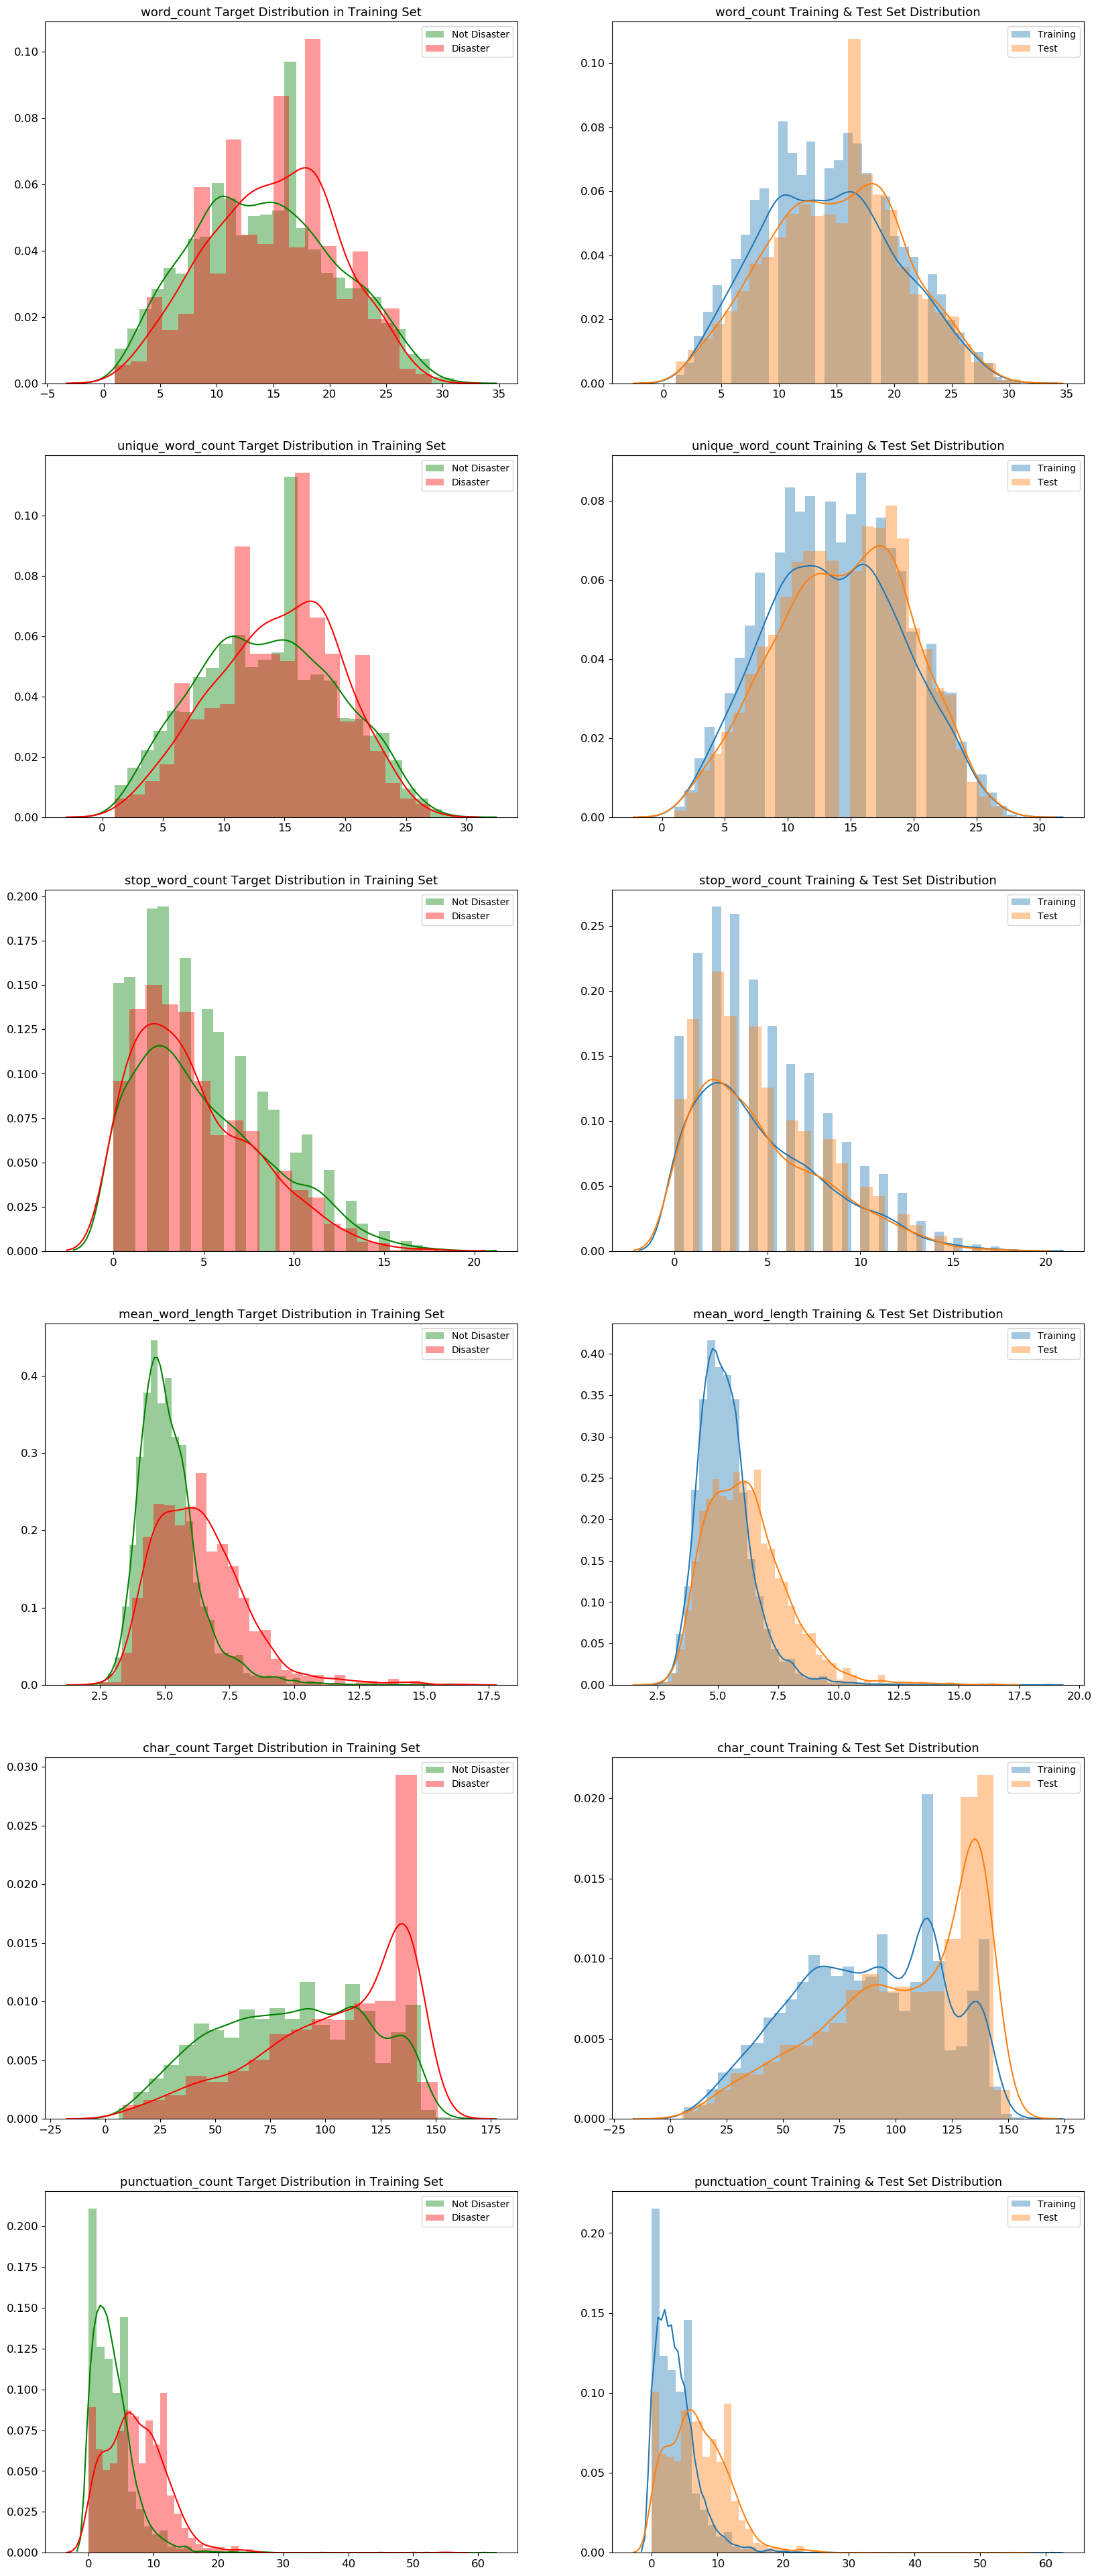

In [247]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
                'char_count', 'punctuation_count']
DISASTER_TWEETS = train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(test.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train[feature], label='Training', ax=axes[i][1])
    sns.distplot(test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

##### The visualization provided show on the left feature-target distribution on train, on the right feature distribution in train and test
All of the new features have similar distributions in training and test set which also proves that training and test set are taken from the same sample.

word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.

All of the new features have information about target as well, but some of them are not good enough such as url_count, hashtag_count and mention_count. Because of this in the part we remove the missing values features (keyword, location) we are going to remove also these.

#### Target

Class distributions are **57%** (4342 rows) for **Not Disaster** and **43%** (3271 rows) for **Disaster**. Classes are almost equally separated so they don't require any balancing for `target`.

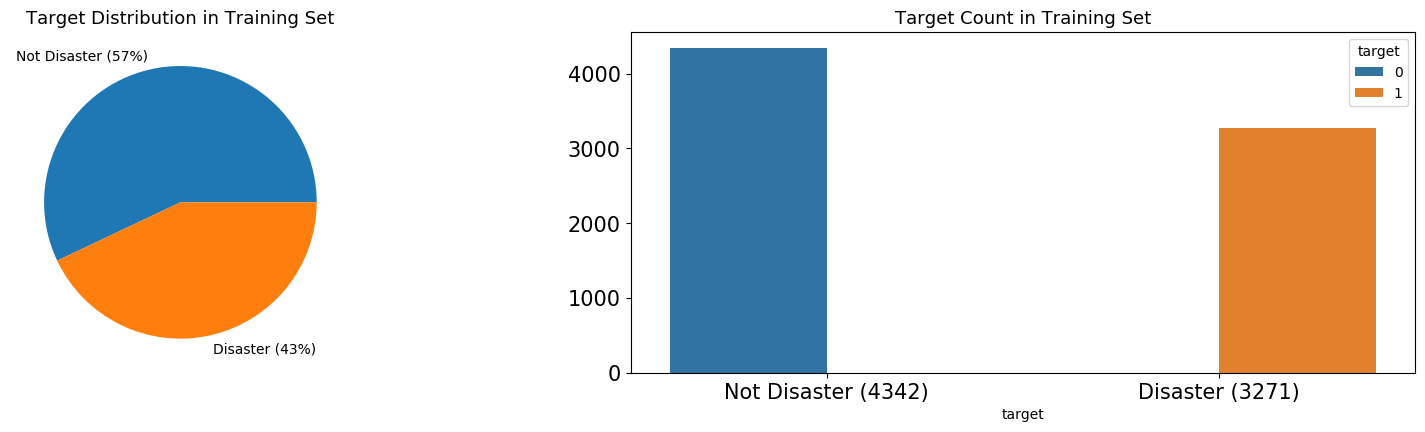

In [249]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

### Data Exploration

##### Example of a tweet when is not a real disaster
This tweet is evidently a random tweet not dealing with anything related to a disaster

In [2]:
train[train["target"] == 0]["text"].values[5]

'this is ridiculous....'

##### Example of a tweet when is it talking about a real disaster
In this case we can evidently understand the opposite from the previus one

In [3]:
train[train["target"] == 1]["text"].values[4]

'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '

##### Small Dataset
Considering the dataset is composed of many retweets the actual information is even smaller, let's move on to try to use everything we can do in order to get the most from the dataset. Data cleaning is going to be crucial for us afterwords.

In [5]:
len(train)

7613

In [7]:
len(test)

3263

##### NA's treatment

- Before jumping on data cleaning a"location" has around 33% of missing values in both datasets so in our opinion it is better to drop this column. 
- Moreover, the keyword column has less than 1% of missing values so we will keep it in case it will be useful in the future

In [9]:
del train['location']

In [10]:
del test['location']

### The dataset has a lot of unstructured tweets which should be "cleaned" in order to make an NLP model
Removing punctuations, stop words will save more computational power  and give us a higher accuracy since they are not related to sentiments.


2- Removing HTTP links

In [11]:
# How many http words has this text?
train.loc[train['text'].str.contains('http')].target.value_counts()

1    2172
0    1799
Name: target, dtype: int64

Creating a new column to show if the tweet has a link (maybe retweeted or a normal link)

In [12]:
train['link'] = 0 
train.link.loc[train['text'].str.contains('http')] = 1

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
import re
    
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_links(text):
    no_link= pattern.sub('',text)
    return no_link

print(train['text'].iloc[33])
print(remove_links(train['text'].iloc[33]))

#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi
#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. 


In [14]:
train['text'] = train['text'].apply(lambda x: remove_links(x))

In [15]:
test['text'] = test['text'].apply(lambda x: remove_links(x))

1- Removing duplicates but keeping count

We realized we have a lot of retweets, so after removing the https: which means a retweet, we will remove all duplicates

In [16]:
train['CountofRetweets'] = 0
train['CountofRetweets'] = train.groupby(['text']).transform('count')

In [17]:
train = train.drop_duplicates(subset='text', keep="last").reset_index(drop=True)

3- Removing usernames (@)

In [20]:
pattern = re.compile('@[^\s]+')

def remove_username(text):
    no_username= pattern.sub('',text)
    return no_username

print(train['text'].iloc[65])
print(remove_links(train['text'].iloc[65]))

@ablaze what time does your talk go until? I don't know if I can make it due to work.
 what time does your talk go until? I don't know if I can make it due to work.


In [21]:
train['text'] = train['text'].apply(lambda x: remove_username(x))

In [22]:
test['text'] = test['text'].apply(lambda x: remove_username(x))

4- Expanding shortened words (don't to do not)

In [23]:
## DO NOT REMOVE STOP WORDS, DONT IS IMPORTANT FOR NEGATION, filter?
## WHAT TO DO WITH WEBSITES, create new column yes and no?

In [24]:
from pycontractions import Contractions
import gensim.downloader as api

model = api.load("glove-twitter-25")
cont = Contractions(kv_model=model)
cont.load_models()


def expand_contractions(text):
    text = list(cont.expand_texts([text], precise=True))[0]
    return text

print(train['text'].iloc[7])
print(expand_contractions(train['text'].iloc[7]))

I'm on top of the hill and I can see a fire in the woods...
I am on top of the hill and I can see a fire in the woods...


In [25]:
train['text'] = train['text'].apply(expand_contractions)

In [26]:
test['text'] = test['text'].apply(expand_contractions)

5- Removal of punctuations

In [27]:
# Our dataset is related to tweets so we will have a lot of @ and # 
from textblob import TextBlob

def punctuations(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

print(train['text'].iloc[3])
print(punctuations(expand_contractions(train['text'].iloc[3])))

13,000 people receive #wildfires evacuation orders in California 
13,000 people receive wildfires evacuation orders in California


In [28]:
train['text'] = train['text'].apply(punctuations)

In [29]:
test['text'] = test['text'].apply(punctuations)

6- Removal of accented characters (café to cafe)

In [30]:
# in this dataset we do not have accented characters, this function will be used in case we are analyzing tweets 
# from France or any country that has accented characters in their languages
import unidecode

def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

# print(train['text'].iloc[3])
# print((remove_accented_chars(train['text'].iloc[3])))

In [31]:
train['text'] = train['text'].apply(remove_accented_chars)

In [32]:
test['text'] = test['text'].apply(remove_accented_chars)

7- Removal of repeated letters

In [33]:
for i in range(0,len(train)):
    train.text.iloc[i] = re.sub(r'(.)\1+', r'\1\1', train.text.iloc[i])


for i in range(0,len(test)):
    test.text.iloc[i] = re.sub(r'(.)\1+', r'\1\1', test.text.iloc[i])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


8- Removal of commonly used words and stopwords

In [34]:
#Option1 

from nltk.corpus import stopwords
import re

def common_stopwords(tweet):
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    tweet = tweet.lower()
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
#     clean_mess = ' '.join(clean_mess)
    return clean_mess

print(train['text'].iloc[12])
print(common_stopwords(train['text'].iloc[12]))


raining flooding Florida TampaBay Tampa 18 or 19 days I have lost count
['raining', 'flooding', 'florida', 'tampabay', 'tampa', 'days', 'lost', 'count']


In [35]:
#Option2 
# We decided not to import the stopwords from nltk.corpus since we wanted to keep the words that negate like no,not,,

# ### list of stop words that need to be removed
# stop_words = ['as', 'in', 'of', 'is', 'are', 'were', 'was', 'it', 'for', 'to', 'from', 'into', 'onto', 
#               'this', 'that', 'being', 'the','those', 'these', 'such', 'a', 'an','i','and','be','you',
#               'have','on','my','do','with', 'or','be','at','by','s','have']

# from nltk import word_tokenize
# import re

# def remove_stopwords(tweet):
#     tweet = re.sub('[^a-zA-Z]', ' ', tweet)
#     tweet = tweet.lower()
#     tokenized_words = word_tokenize(tweet)
#     temp = [word for word in tokenized_words if word not in stop_words]
# #     temp = ' '.join(temp)
#     return temp

# print(train['text'].iloc[12])
# print(remove_stopwords(train['text'].iloc[12]))


Choose between option A and B, we got a lower score using option B where we filter manual the stop words, so we will use option A

In [36]:
train['text'] = train['text'].apply(common_stopwords)

In [37]:
test['text'] = test['text'].apply(common_stopwords)

9- Word Normalization

In [38]:
from nltk.stem.wordnet import WordNetLemmatizer

def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
print((train['text'].iloc[12]))   
print(normalization((train['text'].iloc[12])))

['raining', 'flooding', 'florida', 'tampabay', 'tampa', 'days', 'lost', 'count']
['rain', 'flood', 'florida', 'tampabay', 'tampa', 'days', 'lose', 'count']


In [39]:
train['text'] = train['text'].apply(normalization)

In [40]:
test['text'] = test['text'].apply(normalization)

10- Creating word count variable

In [59]:
train['WordCount'] = train['text'].str.count(' ') + 1

In [60]:
train['WordCount'] = train['text'].str.count(' ') + 1

,id,keyword,text,target,link,CountofRetweets,WordCount,norm_count_word,norm_count_retweets
0,1,NaN,deeds reason earthquake may allah forgive us,1,0,1,7,NaN,0.000000
1,4,NaN,forest fire near la ronge sask canada,1,0,1,7,NaN,0.000000
2,5,NaN,residents ask shelter place notify officer eva...,1,0,1,11,NaN,0.000000
3,6,NaN,people receive wildfires evacuation order cali...,1,0,1,6,NaN,0.000000
4,7,NaN,get send photo ruby alaska smoke wildfires pou...,1,0,1,9,NaN,0.000000
...,...,...,...,...,...,...,...,...,...
6984,10869,NaN,two giant crane hold bridge collapse nearby home,1,1,8,8,NaN,0.304348
6985,10870,NaN,control wild fire california even northern par...,1,0,2,9,NaN,0.043478
6986,10871,NaN,utc km volcano hawaii,1,1,2,4,NaN,0.043478
6987,10872,NaN,police investigate e bike collide car little p...,1,0,2,17,NaN,0.043478


In [43]:
for i in range(0,len(train)):
        train.text.iloc[i] = ' '.join(train.text.iloc[i])

In [44]:
 train['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents ask shelter place notify officer eva...
3       people receive wildfires evacuation order cali...
4       get send photo ruby alaska smoke wildfires pou...
                              ...                        
6984     two giant crane hold bridge collapse nearby home
6985    control wild fire california even northern par...
6986                                utc km volcano hawaii
6987    police investigate e bike collide car little p...
6988    latest home raze northern california wildfire ...
Name: text, Length: 6989, dtype: object

In [45]:
#Create our dictionary 
uniqueWordFrequents = {}
for tweet in train.text:
    for word in tweet.split():
        if(word in uniqueWordFrequents.keys()):
            uniqueWordFrequents[word] += 1
        else:
            uniqueWordFrequents[word] = 1
            
#Convert dictionary to dataFrame
uniqueWordFrequents = pd.DataFrame.from_dict(uniqueWordFrequents,orient='index',columns=['Word Frequent'])
uniqueWordFrequents.sort_values(by=['Word Frequent'], inplace=True, ascending=False)
uniqueWordFrequents.head(10)

,Word Frequent
get,418
like,383
fire,339
amp,333
go,309
bomb,201
one,195
say,189
people,185
would,185


In [46]:
uniqueWordFrequents = uniqueWordFrequents[uniqueWordFrequents['Word Frequent'] >= 20]
print(uniqueWordFrequents.shape)

(654, 1)


Normalizing the features that were created

In [61]:
train['norm_count_word']=(train.WordCount-train.WordCount.min())/(train.WordCount.max()-train.WordCount.min())
train.norm_count_word

0       0.272727
1       0.272727
2       0.454545
3       0.227273
4       0.363636
          ...   
6984    0.318182
6985    0.363636
6986    0.136364
6987    0.727273
6988    0.318182
Name: norm_count_word, Length: 6989, dtype: float64

In [48]:
train['norm_count_retweets']=(train.CountofRetweets-train.CountofRetweets.min())/(train.CountofRetweets.max()-train.CountofRetweets.min())
train.norm_count_retweets

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
6984    0.304348
6985    0.043478
6986    0.043478
6987    0.043478
6988    0.521739
Name: norm_count_retweets, Length: 6989, dtype: float64

In [49]:
# from sklearn.feature_extraction.text import CountVectorizer

# counVec = CountVectorizer(max_features = uniqueWordFrequents.shape[0])
# bagOfWords = counVec.fit_transform(train.text).toarray()

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer  

tfidfconverter = TfidfVectorizer(max_features=uniqueWordFrequents.shape[0], min_df=5, max_df=0.7)  
X1 = tfidfconverter.fit_transform(train.text).toarray()
#if remove X, bagofwords should be X


Adding normalized variables

In [51]:
train.norm_count_retweets

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
6984    0.304348
6985    0.043478
6986    0.043478
6987    0.043478
6988    0.521739
Name: norm_count_retweets, Length: 6989, dtype: float64

In [63]:
import numpy as np
import pandas as pd

X = pd.DataFrame(X1)

new_X = pd.concat([X, train.norm_count_retweets], axis = 1,ignore_index = True)
new_X = pd.concat([new_X, train.norm_count_word], axis = 1,ignore_index = True)
new_X = pd.concat([new_X, train.link], axis = 1, ignore_index = True)

In [64]:
new_X

,0,1,2,3,4,5,6,7,8,9,...,647,648,649,650,651,652,653,654,655,656
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.272727,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.272727,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.454545,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.227273,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.363636,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.304348,0.318182,1
6985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.363636,0
6986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.136364,1
6987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.727273,0


In [54]:
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.naive_bayes import MultinomialNB

# text_clf = Pipeline([('vect', CountVectorizer(max_features = uniqueWordFrequents.shape[0], min_df=5, max_df=0.7 )),
#                       ('tfidf', TfidfTransformer()),
#                       ('clf', MultinomialNB()) ])
# text_clf = text_clf.fit(X_train,y_train)

In [55]:
# import numpy as np
# predicted = text_clf.predict(X_test)
# np.mean(predicted == y_test)

In [56]:
# y_pred = text_clf.predict(X_test)
# print(' F1 Score is      : ' ,f1_score(y_test,y_pred))

In [65]:
from sklearn.model_selection import train_test_split

y = train['target']
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X_train , X_test , y_train , y_test = train_test_split(new_X,y,test_size=0.20, random_state=55, shuffle =True)
print('data splitting successfully')

X shape =  (6989, 654)
y shape =  (6989,)
data splitting successfully


1- Decision Tree Classifier

In [67]:
from sklearn.tree import DecisionTreeClassifier

decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=55)

decisionTreeModel.fit(X_train,y_train)

print("decision Tree Classifier model run successfully")

decision Tree Classifier model run successfully


2- Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

LogisticRegression = LogisticRegression(penalty='l2', 
                                        solver='saga', 
                                        random_state = 55)  

LogisticRegression.fit(X_train,y_train)

print("LogisticRegression Classifier model run successfully")

LogisticRegression Classifier model run successfully


3- Support Vector Machine Model

In [69]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

SVClassifier = SVC(kernel= 'linear',
                   degree=3,
                   max_iter=10000,
                   C=2, 
                   random_state = 55)

SVClassifier.fit(X_train,y_train)

print("SVClassifier model run successfully")

SVClassifier model run successfully


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


4- Gradient Boosting Model

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

gradientBoostingModel = GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 100,
                                                   max_depth = 30,
                                                   random_state=55)

gradientBoostingModel.fit(X_train,y_train)

print("gradient Boosting Classifier model run successfully")

gradient Boosting Classifier model run successfully


5- Multinomial Naive Bayes Model

In [71]:
from sklearn.naive_bayes import MultinomialNB

multinomialNBModel = MultinomialNB(alpha=0.1)
multinomialNBModel.fit(X_train,y_train)

print("multinomialNB model run successfully")

multinomialNB model run successfully


In [72]:
from sklearn.metrics import f1_score

#evaluation Details
models = [decisionTreeModel, gradientBoostingModel,  LogisticRegression,
          SVClassifier, multinomialNBModel]

for model in models:
    print(type(model).__name__,' Train Score is   : ' ,model.score(X_train, y_train))
    print(type(model).__name__,' Test Score is    : ' ,model.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    print(type(model).__name__,' F1 Score is      : ' ,f1_score(y_test,y_pred))
    print('--------------------------------------------------------------------------')

DecisionTreeClassifier  Train Score is   :  0.9896261849400823
DecisionTreeClassifier  Test Score is    :  0.7124463519313304
DecisionTreeClassifier  F1 Score is      :  0.6242990654205608
--------------------------------------------------------------------------
GradientBoostingClassifier  Train Score is   :  0.8715793239134323
GradientBoostingClassifier  Test Score is    :  0.765379113018598
GradientBoostingClassifier  F1 Score is      :  0.6339285714285714
--------------------------------------------------------------------------
LogisticRegression  Train Score is   :  0.8193525308531568
LogisticRegression  Test Score is    :  0.7889842632331903
LogisticRegression  F1 Score is      :  0.704112337011033
--------------------------------------------------------------------------
SVC  Train Score is   :  0.8300840636737614
SVC  Test Score is    :  0.7882689556509299
SVC  F1 Score is      :  0.705765407554672
--------------------------------------------------------------------------
Mult

In [73]:
train


,id,keyword,text,target,link,CountofRetweets,WordCount,norm_count_word,norm_count_retweets
0,1,NaN,deeds reason earthquake may allah forgive us,1,0,1,7,0.272727,0.000000
1,4,NaN,forest fire near la ronge sask canada,1,0,1,7,0.272727,0.000000
2,5,NaN,residents ask shelter place notify officer eva...,1,0,1,11,0.454545,0.000000
3,6,NaN,people receive wildfires evacuation order cali...,1,0,1,6,0.227273,0.000000
4,7,NaN,get send photo ruby alaska smoke wildfires pou...,1,0,1,9,0.363636,0.000000
...,...,...,...,...,...,...,...,...,...
6984,10869,NaN,two giant crane hold bridge collapse nearby home,1,1,8,8,0.318182,0.304348
6985,10870,NaN,control wild fire california even northern par...,1,0,2,9,0.363636,0.043478
6986,10871,NaN,utc km volcano hawaii,1,1,2,4,0.136364,0.043478
6987,10872,NaN,police investigate e bike collide car little p...,1,0,2,17,0.727273,0.043478


In [74]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# pipeline = Pipeline([
#     ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
#     ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#     ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
# ])

depending on accuracy choose option 1 or 2 in stop words and try to  remove not repetetive words